In [34]:
import numpy as np
import IO
import SVD
from matplotlib import pyplot as plt
import time
import tools
import Wannier2Bloch

In [35]:
alat = 7.676
outdir = "./Plots/"
DataDir = "../../DATA/"
prefix = "lif"
at = (alat / 2.0) * np.array([[-1., 0., 1.], [0., 1., 1.], [-1., 1., 0.]]).T
k_mesh = [6,6,6]
G = np.array([0,0,0]) #gamma 
L = np.array([0.5,0.5,0.5])
X = np.array([0.5, 0.0, 0.5])
K = np.array([0.375, 0.3750, 0.75])
W = np.array([ 0.5000000000,0.2500000000,0.7500000000])
u = np.array([0.6250000000	, 0.2500000000	, 0.6250000000])
path1 = np.array([[G,X],[X,W],[W,K],[K,G],[G,L],[L,u],[u,W],[W,L],[L,K]])
xticks_labels1 = ['G','X','W','K','G','L','u','W','L','K']
path2 = np.array([[L,G],[G,K]])
xticks_labels2 = ['L','G','K']

### Import Hamiltonian and Dynamical Matrix
  - Generate R vectors
  - Sort Data structures

Reading Text Data: ../../DATA/epwdata.fmt
Dims: Bands=3, Modes=6, R_k=279, R_g=279, R_q=279
!All the file has been red!
Replicating wigner.f90 scan loops...

Total vectors found: 279 (Should be 279)


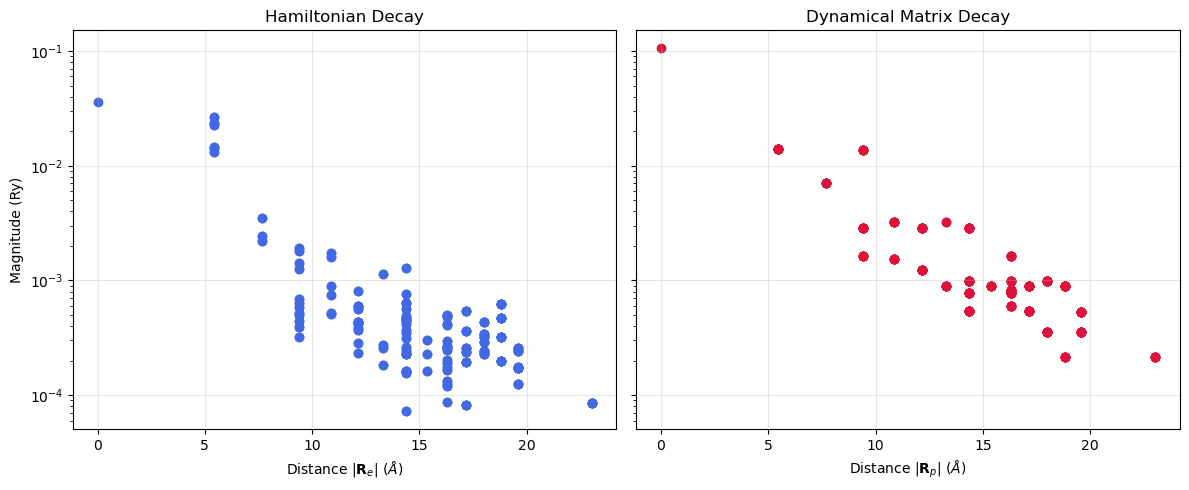

3


In [36]:
file_fmt = DataDir + "epwdata.fmt"
H_sort, D_sort,R_sort ,R, ef ,nbnd, nrr_k, nmodes, nrr_q, nrr_g = IO.read_epwdata_fmt(file_fmt, at,k_mesh,True,outdir)
print(nbnd)

### Import el-ph matrix in Coarse K mesh

In [37]:
file_epb = DataDir + prefix + ".epb1"
nq = 216
G_bloch,q_bloch = IO.read_epb_mixed_record(file_epb,nq,nbnd,nmodes)
if np.isnan(G).any() or np.isinf(G).any():
    print("CRITICAL WARNING: Your tensor contains NaN or Inf values!")
    # Optional: clean it
    G_bloch = np.nan_to_num(G)

Reading ../../DATA/lif.epb1...
  - Total Record Bytes: 112112860
  - nqc (q-points in file): 216
  - Reading epmatq (2519424 complex elements)...
  ! Warning: 71667288 bytes remaining in record (padding?).


### Import el-ph matrix in Wannier space
    -plot Decay
    -Sort by distance
    - Match VASP shape

Reading ../../DATA/lif.epmatwp...
G shape loaded: (279, 279, 6, 3, 3)


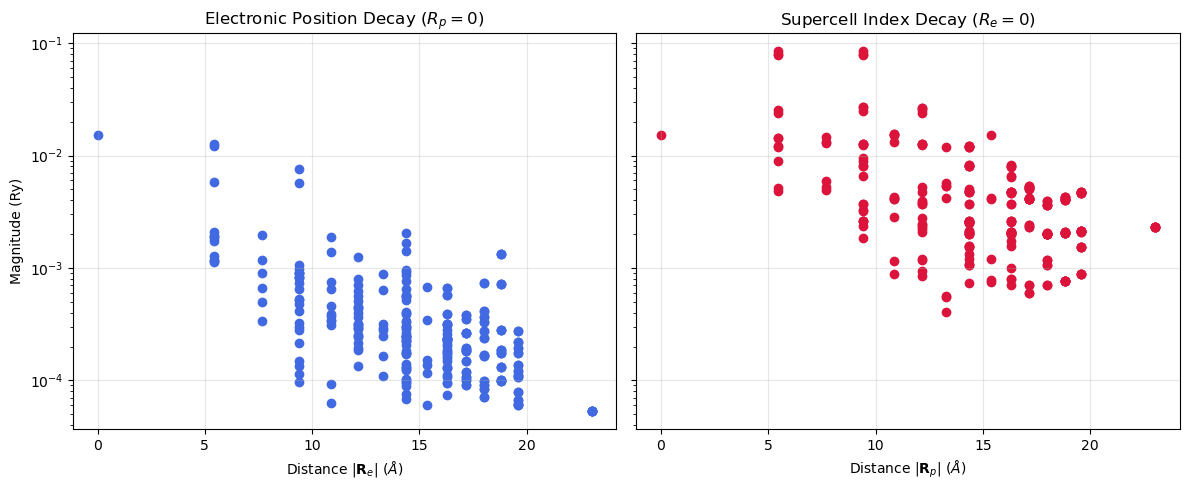

In [38]:
file_epmatwp = DataDir + prefix +  ".epmatwp"
G =  IO.read_epmatwp(file_epmatwp,nbnd, nrr_k, nmodes, nrr_g,R,PLOT=True,outdir = outdir)

### Obtain SVD decomposition

In [39]:
#Wannier
rel_error, x_percent = SVD.svd_trend(G,nbnd,nbnd,nmodes)
U,s,Vt = SVD.SVD(G,nbnd,nbnd,nmodes)

#Bloch
rel_error_k,x_perc_k = SVD.svd_trend(G_bloch,nbnd,nbnd,nmodes)
U_k,s_k,Vt_k = SVD.SVD(G_bloch,nbnd,nbnd,nmodes)

err_hooi_bloch,  x_hooi_bloch, CORES_bloch,FACTORS_bloch = SVD.HOOI_trend(G_bloch, nbnd, nbnd, nmodes, step=10,rmax=220, collect = True)
err_hooi,  x_hooi,CORES,FACTORS = SVD.HOOI_trend(G, nbnd, nbnd, nmodes, step=5,rmax=279,collect = True)

Number of SVs: 279
Number of SVs: 216
Number of Ranks to test: 220 (Step: 10)
Rank 1/220 -> Rel. Error^2: 9.99e-01
Rank 11/220 -> Rel. Error^2: 9.87e-01
Rank 21/220 -> Rel. Error^2: 9.65e-01
Rank 31/220 -> Rel. Error^2: 9.36e-01
Rank 41/220 -> Rel. Error^2: 9.01e-01
Rank 51/220 -> Rel. Error^2: 8.62e-01


KeyboardInterrupt: 

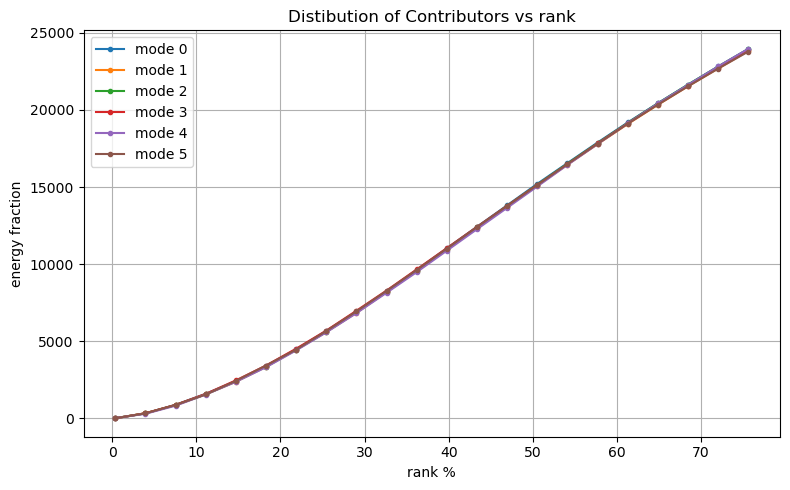

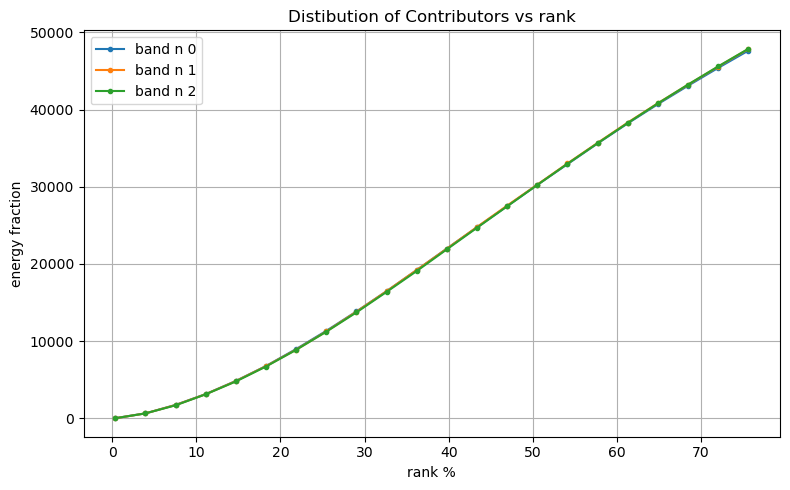

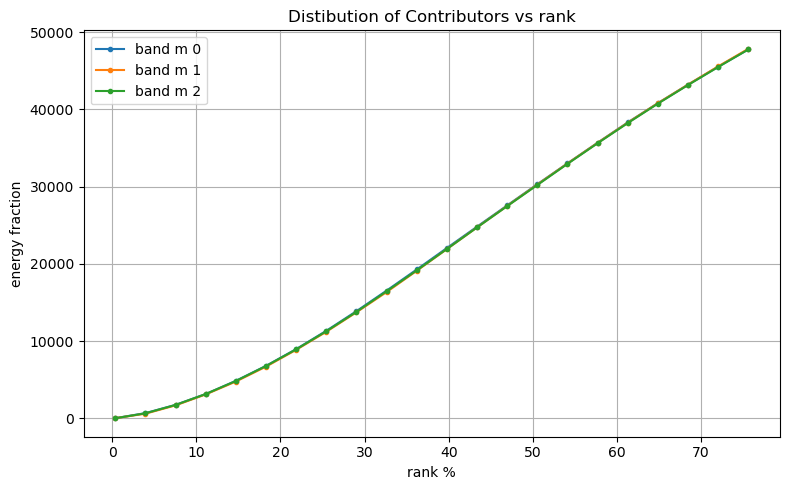

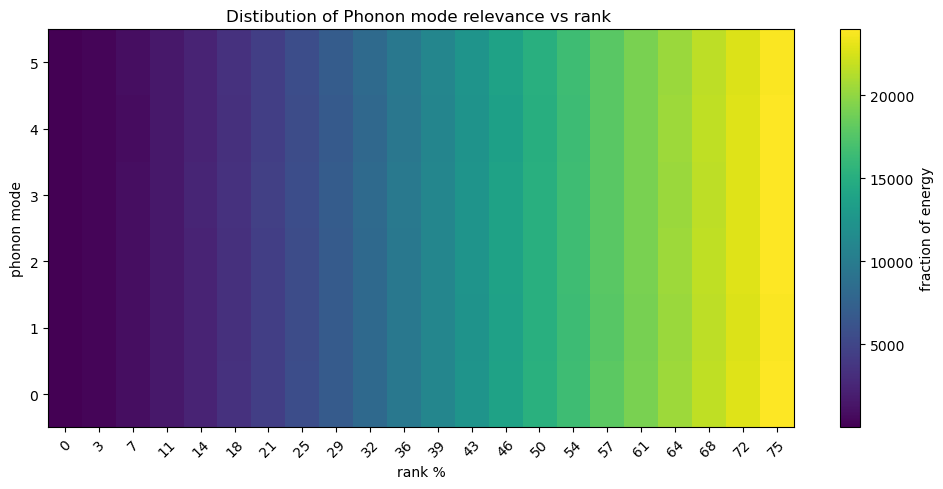

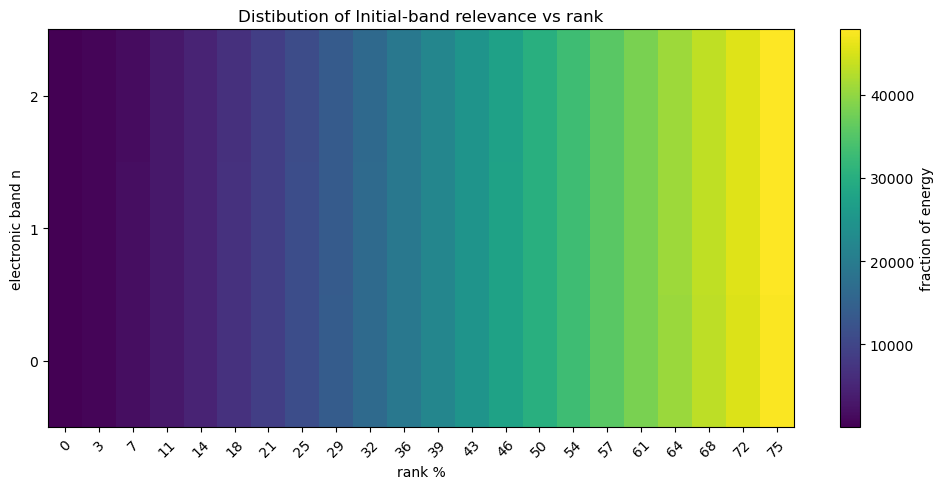

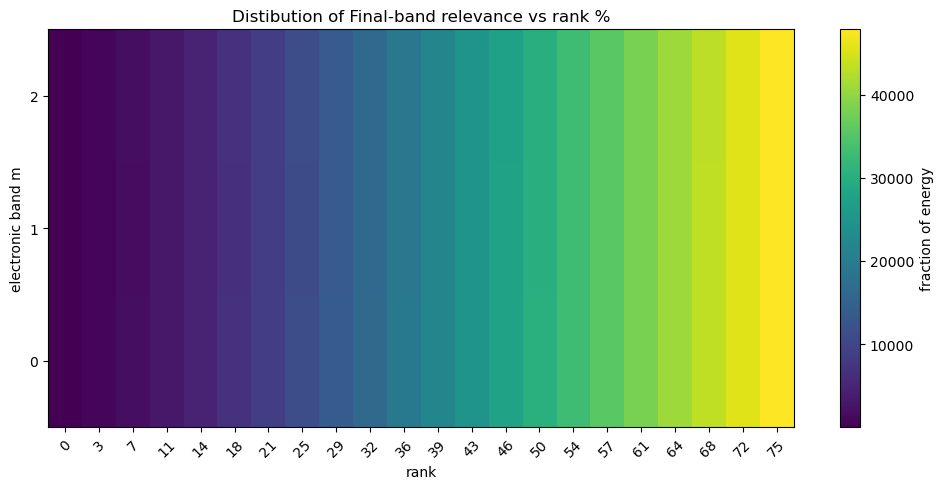

In [45]:
def core_energy_marginals(core):
    """core: (Rk, Rq, Rph, Rn, Rm) -> energy marginals over each mode."""
    W = np.abs(core)**2
    E_tot = W.sum()

    E_ph = W.sum(axis=(0,1,3,4))  # (Rph,)
    E_n  = W.sum(axis=(0,1,2,4))  # (Rn,)
    E_m  = W.sum(axis=(0,1,2,3))  # (Rm,)

    return E_tot, E_ph, E_n, E_m

#Map rank-energy E_rank (R,) to physical-index scores S_phys (N,)
#using S = sum_r |U[n,r]|^2 * E_rank[r]
def physical_scores_from_factor(E_rank, U_phys_rank):
    return (np.abs(U_phys_rank)**2 @ E_rank)

#For each rank setting, compute:
# top physical phonon modes
# top physical electronic bands (initial n and final m separately)
def analyze_relevant_modes_bands_over_ranks(CORES, FACTORS, ranks, normalize=True):
    ph_scores_list = []
    n_scores_list  = []
    m_scores_list  = []

    for i, r in enumerate(ranks):
        core = CORES[i]          # (Rk,Rq,Rph,Rn,Rm)
        U_ph = FACTORS[i][2]     # (Nph,Rph)
        U_n  = FACTORS[i][3]     # (Nb,Rn)
        U_m  = FACTORS[i][4]     # (Nb,Rm)

        _, E_ph, E_n, E_m = core_energy_marginals(core)

        # Map rank importance -> physical indices
        S_ph = physical_scores_from_factor(E_ph, U_ph)  # (Nph,)
        S_n  = physical_scores_from_factor(E_n,  U_n)   # (Nb,)
        S_m  = physical_scores_from_factor(E_m,  U_m)   # (Nb,)

        if normalize:
            S_ph = S_ph / (S_ph.sum())
            S_n  = S_n  / (S_n.sum())
            S_m  = S_m  / (S_m.sum())

        ph_scores_list.append(S_ph)
        n_scores_list.append(S_n)
        m_scores_list.append(S_m)

    return {
        "ranks": np.array(ranks),
        "ph_scores": np.array(ph_scores_list),  # (n_ranks, Nph)
        "n_scores":  np.array(n_scores_list),   # (n_ranks, Nb)
        "m_scores":  np.array(m_scores_list),   # (n_ranks, Nb)
    }

def plot_heatmap(scores, ranks,rmax, xlabel, ylabel, title):
    plt.figure(figsize=(10,5))
    plt.imshow(scores.T, aspect='auto', origin='lower')
    plt.colorbar(label="fraction of energy")
    plt.yticks(np.arange(scores.shape[1]))
    plt.xticks(np.arange(len(ranks)), labels=np.array(ranks/rmax*100,dtype=int), rotation=45)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.tight_layout()
    plt.show()

def plot_curves(scores, ranks,rmax, label_prefix="idx"):
    #idx = np.argsort(scores[-1])[::-1]
    plt.figure(figsize=(8,5))
    for j in range((scores.shape[1])):
        plt.plot(ranks/rmax*100, scores[:, j], marker="o",linestyle="-",markersize=3, label=f"{label_prefix}{j}")
    plt.xlabel("rank %")
    plt.ylabel("energy fraction")
    plt.title(f"Distibution of Contributors vs rank")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

ranks = np.arange(1,220,10) # same used for generation
out = analyze_relevant_modes_bands_over_ranks(CORES_bloch, FACTORS_bloch, ranks,False)
rmax=279
# phonons
plot_curves(out["ph_scores"], out["ranks"],rmax, label_prefix="mode ")
# electrons (initial bands)
plot_curves(out["n_scores"], out["ranks"],rmax, label_prefix="band n ")
# electrons (final bands)
plot_curves(out["m_scores"], out["ranks"],rmax, label_prefix="band m ")

# oppure heatmaps:
plot_heatmap(out["ph_scores"], out["ranks"],rmax, xlabel="rank %", ylabel="phonon mode",
             title="Distibution of Phonon mode relevance vs rank ")
plot_heatmap(out["n_scores"], out["ranks"], rmax, xlabel="rank %", ylabel="electronic band n",
             title="Distibution of Initial-band relevance vs rank")
plot_heatmap(out["m_scores"], out["ranks"],rmax, xlabel="rank", ylabel="electronic band m",
             title="Distibution of Final-band relevance vs rank %")

(56,)


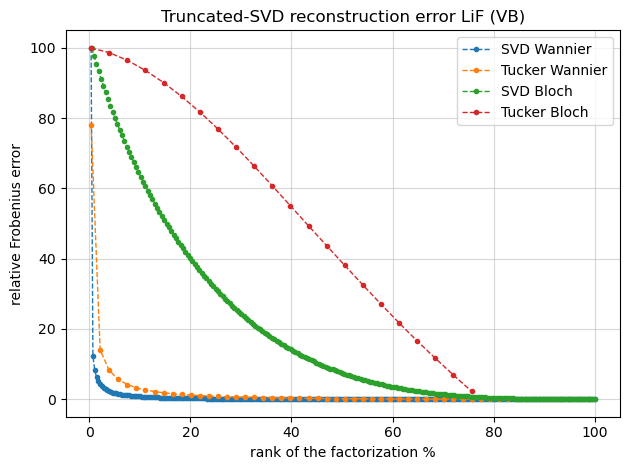

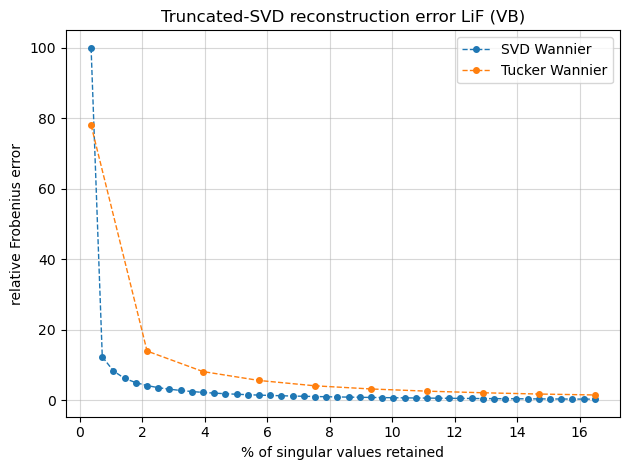

In [ ]:
#Full Trend
fig = plt.figure()
rank_percent = np.arange(1, x_percent.size + 1) / x_percent.size * 100
rank_percent_tucker = np.arange(1, 279 + 1, 5) / x_percent.size * 100
plt.plot(rank_percent[:], rel_error*100,linestyle="--", marker = "o", markersize = 3,linewidth=1, label="SVD Wannier")
plt.plot(rank_percent_tucker, err_hooi*100, linestyle="--", marker = "o", markersize = 3,linewidth=1,label="Tucker Wannier")
rank_percent_tucker_b = np.arange(1, 220 + 1, 10) / x_percent.size * 100
rank_percent_k = np.arange(1, x_perc_k.size + 1) / x_perc_k.size * 100
plt.plot(rank_percent_k, rel_error_k*100, linestyle="--", marker = "o", markersize = 3,linewidth=1,label="SVD Bloch")
plt.plot(rank_percent_tucker_b, err_hooi_bloch*100,linestyle="--", marker = "o", markersize = 3,linewidth=1, label="Tucker Bloch")
print(x_hooi.shape)
plt.xlabel("rank of the factorization %")
plt.ylabel("relative Frobenius error")
plt.legend()
plt.grid(alpha=0.5)
plt.title("Truncated-SVD reconstruction error LiF (VB)")
plt.tight_layout()
plt.show()
fig.savefig(outdir+"SVD_trend.jpg")


#ZOOM
fig = plt.figure()
plt.plot(rank_percent[0:46], rel_error[0:46]*100,linestyle="--", marker = "o", markersize = 4,linewidth=1, label="SVD Wannier")
plt.plot(rank_percent_tucker[0:10], err_hooi[0:10]*100,linestyle="--", marker = "o", markersize = 4,linewidth=1, label="Tucker Wannier")
plt.xlabel("% of singular values retained")
plt.ylabel("relative Frobenius error")
plt.legend()
plt.title("Truncated-SVD reconstruction error LiF (VB)")
plt.tight_layout()
plt.grid(alpha=0.5)
plt.show()
fig.savefig(outdir+"SVD_zoom.jpg")



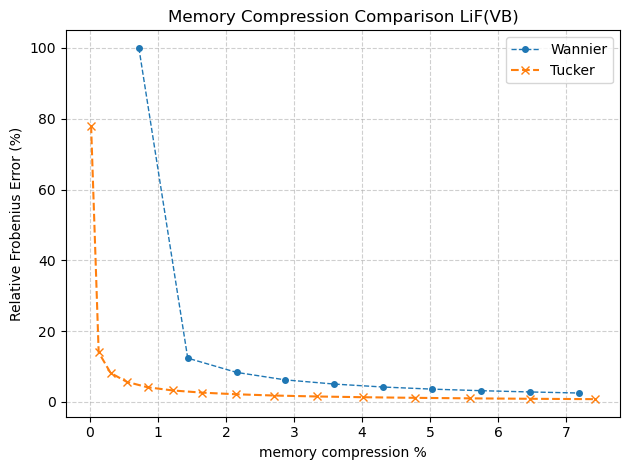

In [ ]:
# ZOOM PLOT memory size
#x_hooi might have different spacing due to 'step=5'.
fig = plt.figure()

# Wannier Zoom
plt.plot(x_percent[0:10], rel_error[0:10] * 100, linestyle="--", marker = "o", markersize = 4,linewidth=1, label="Wannier")

# Tucker Zoom (Filter points that are within the first 50% range)
mask_hooi = x_hooi <= x_percent[10] 
plt.plot(x_hooi[mask_hooi], err_hooi[mask_hooi] * 100, "x--", label="Tucker")

plt.xlabel("memory compression %")
plt.ylabel("Relative Frobenius Error (%)")
plt.title("Memory Compression Comparison LiF(VB)")
plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig(outdir + "SVD_Tucker_zoom.jpg")

LR factorization: 0.31026482582092285 seconds 
Relative error with 4% SV = 2.07%
LR factorization: 0.15318703651428223 seconds 
Relative error with 4% SV = 83.6%


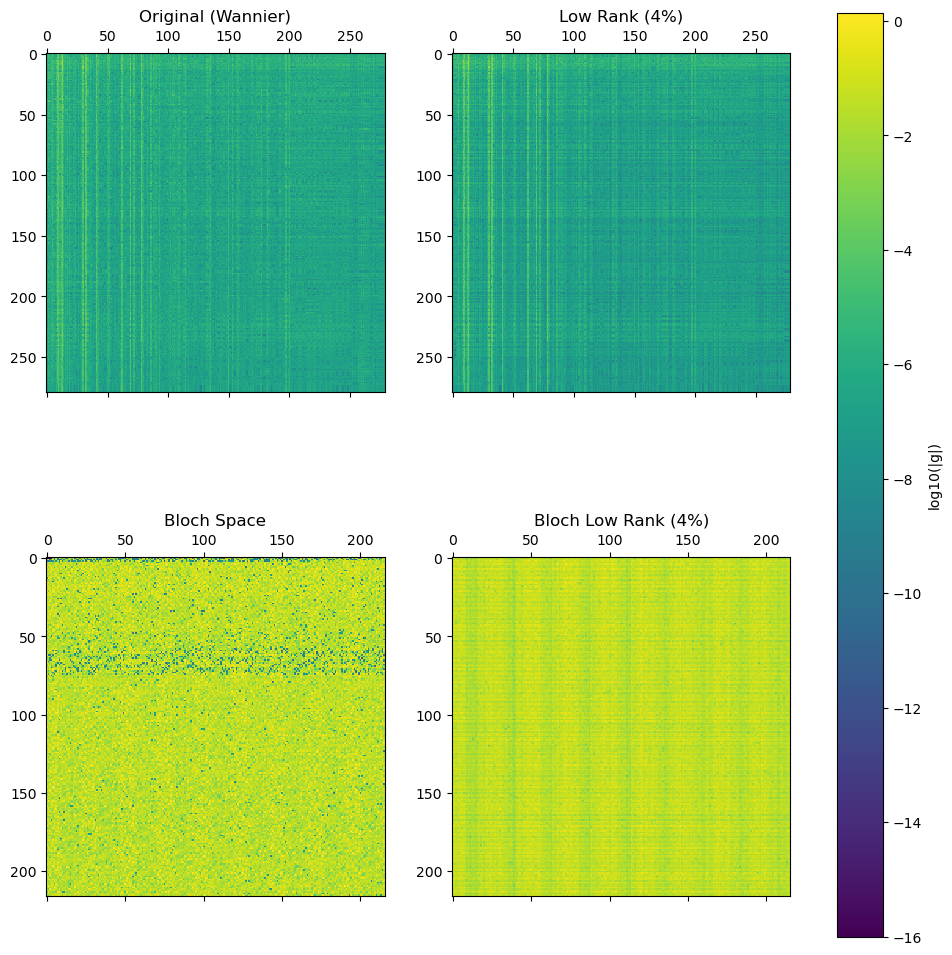

In [ ]:
G_abs = np.abs(G)
perc = 4
rank = int(nrr_k * perc / 100)
rank_bloch = int(nq*perc/100)
# Calculate Low Rank Approximation
start_time = time.time()
G_LR2 = SVD.getLowRank(U, s, Vt, rank)
print("LR factorization: %s seconds " % (time.time() - start_time))


# Calculate Error
diff = np.abs(G_LR2 - G)**2
relative_error = np.sum(diff) / np.sum(G_abs**2)
print(f"Relative error with {perc}% SV = {relative_error*100:0.3}%")

start_time = time.time()
G_LR2_k = SVD.getLowRank(U_k, s_k, Vt_k, rank_bloch)
print("LR factorization: %s seconds " % (time.time() - start_time))


# Calculate Error
diff = np.abs(G_LR2_k - G_bloch)**2
relative_error = np.sum(diff) / np.sum(np.abs(G_bloch)**2)
print(f"Relative error with {perc}% SV = {relative_error*100:0.3}%")

# Pre-calculate the log10 data slices
#tiny epsilon (1e-16) prevents log(0) errors
slice_orig = np.log10(np.abs(G[..., 4, 2, 0]) + 1e-16)
slice_lr   = np.log10(np.abs(G_LR2[..., 4, 2, 0]) + 1e-16)
slice_bloch = np.log10(np.abs(G_bloch[..., 4, 2, 0]) + 1e-16)
slice_lr_bloch   = np.log10(np.abs(G_LR2_k[..., 4, 2, 0]) + 1e-16)

# Determine Global Min/Max for the Color Scale
global_min = min(slice_orig.min(), slice_lr.min(), slice_bloch.min(),slice_lr_bloch.min())
global_max = max(slice_orig.max(), slice_lr.max(), slice_bloch.max(),slice_lr_bloch.max())

fig, axes = plt.subplots(2, 2, figsize=(12, 12))
# Plot Original
im1 = axes[0][0].matshow(slice_orig, vmin=global_min, vmax=global_max)
axes[0][0].set_title("Original (Wannier)")
# Plot Low Rank
im2 = axes[0][1].matshow(slice_lr, vmin=global_min, vmax=global_max)
axes[0][1].set_title(f"Low Rank ({perc}%)")
# Plot Bloch
im3 = axes[1][0].matshow(slice_bloch, vmin=global_min, vmax=global_max)
axes[1][0].set_title("Bloch Space")
#Plot Bloch Low Rank
im4 = axes[1][1].matshow(slice_lr_bloch, vmin=global_min, vmax=global_max)
axes[1][1].set_title(f"Bloch Low Rank ({perc}%)")

# Add a single shared colorbar
fig.colorbar(im1, ax=axes.ravel().tolist(), label="log10(|g|)")

plt.show()
fig.savefig(outdir+"matrixPattern.jpg")

### Computational Complexity Considerations
The gain is only in the time to perform the  Fourier Transform from R to K space:

$ {g}_{i j k \alpha}(\mathbf{k'}, \mathbf{q'}) = \sum_{\mathbf{R}_p, \mathbf{R}_e} e^{i\mathbf{k'}\mathbf{R}_e + i\mathbf{q'}\mathbf{R}_p} {g}_{i j k \alpha}(\mathbf{R}_e, \mathbf{R}_p) \to O(N_{\mathbf{R}}^2) \\$

Instead one can do: 
$ \\ {g}_{i j k \alpha}^{rank}(\mathbf{k'}, \mathbf{q'}) = \sum_{\gamma=1}^{rank} s_{i j k \alpha}^{\gamma} u_{j k \alpha}^{\gamma}(\mathbf{k'}) v_{i j k \alpha}^{\gamma}(\mathbf{q'}) \to O(rank)\\ $

$u_{ i j k \alpha}^{\gamma}(\mathbf{k'}) = \sum_{\mathbf{R}_e} e^{i\mathbf{k'}\mathbf{R}_e} u_{i j k \alpha}^{\gamma}(\mathbf{R}_e)  $ 

$v_{i j k \alpha}^{\gamma}(\mathbf{q'}) = \sum_{\mathbf{R}_p} e^{i\mathbf{q'}\mathbf{R}_p} v_{i j k \alpha}^{\gamma}(\mathbf{R}_p) \to O(N_{\mathbf{R}}) \\$

Two times for each $\gamma$  $ \to O(rank \times N_{\mathbf{R}})\\$
$rank = 1,...,N_{\mathbf{R}} \\$

Plus the fixed overhead in both cases to interpolate ($O(N_{\mathbf{R}})$) and diagonalize $H$ and $D$, which is negligible being $O({N^3_{bands}})$ and  $O({N^3_{modes}})$ respectively.



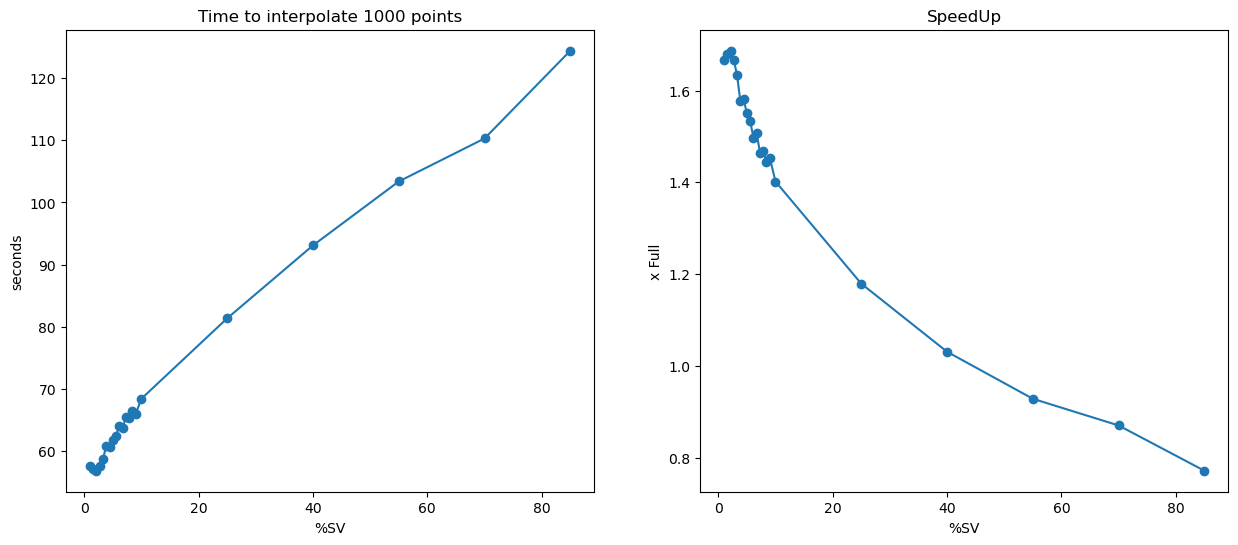

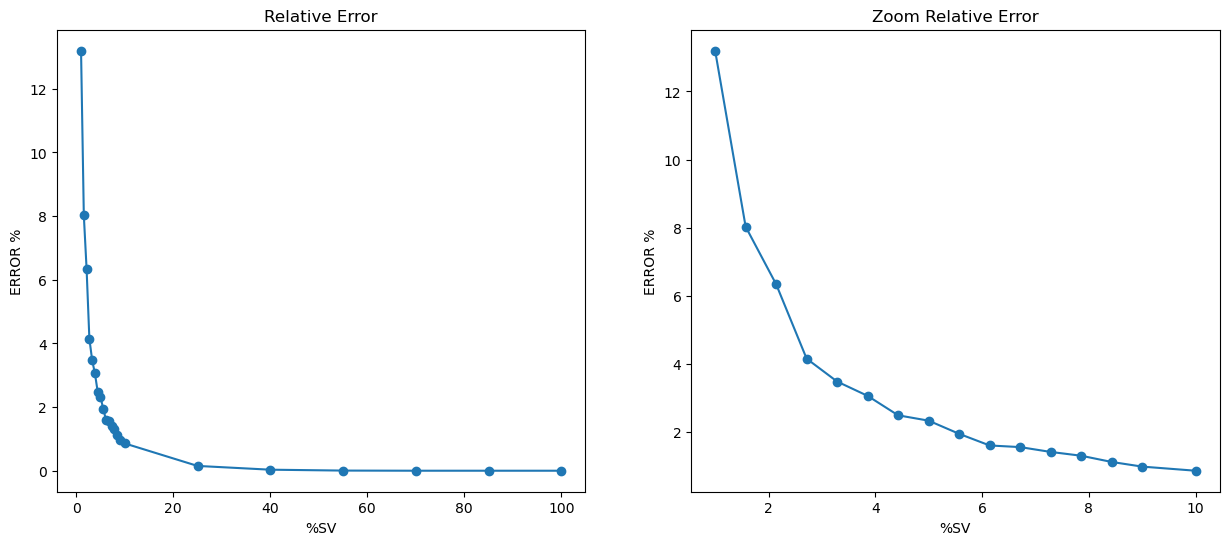

In [ ]:
N = int(5*1e3)
b_lat = tools.get_reciprocal_lattice(at)
perc1, times1, errors1 = tools.performance_analysis(N,b_lat,H_sort,D_sort,G,R_sort,U,Vt,s,outdir)

In [ ]:
import tensorly as tl
from tensorly.decomposition import tucker
import time

tl.set_backend("numpy")
RY_TO_EV    = 13.605698066

def tucker_resolve_core(CORES, FACTORS, ranks):
    CORES_RESOLVED = []
    for i_r in range(ranks.size):
        CORES_RESOLVED.append(np.einsum("RSVNM, vV, nN, mM -> RSvnm", CORES[i_r],FACTORS[i_r][2],FACTORS[i_r][3],FACTORS[i_r][4],optimize=True))
    return CORES_RESOLVED

def fourier_Tucker(core, A, B, q, k, R):
    """
    core: (r_e, r_p, v, i, j)
    A:    (N_R, r_e)   [mode R_e]
    B:    (N_R, r_p)   [mode R_p]
    R:    (N_R, 3)  (stesso R_sort usato nel BENCHMARK)
    """
    exp_k = np.exp(1j * k @ R.T)
    if k.ndim == 1:
        exp_k = exp_k.reshape(1, -1)

    exp_q = np.exp(1j * q @ R.T)
    if q.ndim == 1:
        exp_q = exp_q.reshape(1, -1)

    # A_k: (k, r_e), B_q: (q, r_p)
    A_k = np.einsum("kR,Ra->ka", exp_k, A, optimize=True)
    B_q = np.einsum("qR,Rb->qb", exp_q, B, optimize=True)

    # G_FT: (k, q, v, i, j)
    G_FT = np.einsum("ka,abvij,qb->kqvij", A_k, core, B_q, optimize=True)
    return G_FT

def performance_analysis_FT_only_compare_with_full(
    N, b_lat,
    R_sort,
    G_wan,                
    U, Vt, s,
    CORES, FACTORS,
    outdir="",
    step=5,
    rmax=0,
    resolve_core_offline=True,
):
    if rmax == 0:
        rmax = s.shape[0]

    ranks  = np.arange(1, rmax + 1, step)
    points = ranks.size
    perc   = ranks / s.shape[0] * 100

    K = tools.get_random_k_primitive(b_lat, N)
    q0 = np.array([0, 0, 0])

    # OFFLINE core-resolve (fuori timing)
    if resolve_core_offline:
        CORES_R = tucker_resolve_core(CORES, FACTORS, ranks)
    else:
        CORES_R = CORES

    time_full   = 0.0
    time_svd    = np.zeros(points, dtype=float)
    time_tucker = np.zeros(points, dtype=float)

    for i_k in range(N):
        k = K[i_k]

        # precompute exp_k, exp_q (stesso per tutti i metodi)
        exp_k = np.exp(1j * k @ R_sort.T).reshape(1, -1)    # (1, N_R)
        exp_q = np.exp(1j * q0 @ R_sort.T).reshape(1, -1)   # (1, N_R)

        # -------- FULL FT-only --------
        t0 = time.time()
        _ = np.einsum("kS,qR,SRvij->kqvij", exp_k, exp_q, G_wan, optimize=True)
        time_full += time.time() - t0

        for i_r in range(points):
            r = ranks[i_r]

            # -------- SVD FT-only --------
            U_red  = U[:, :r, ...]
            Vt_red = Vt[:r, ...]
            s_red  = s[:r, ...]

            t0 = time.time()
            _ = Wannier2Bloch.fourierANDlr(U_red, Vt_red, s_red, q0, k, R_sort)
            time_svd[i_r] += time.time() - t0

            # -------- Tucker FT-only --------
            A = FACTORS[i_r][0]
            B = FACTORS[i_r][1]
            core = CORES_R[i_r]

            t0 = time.time()
            _ = fourier_Tucker(core, A, B, q0, k, R_sort)
            time_tucker[i_r] += time.time() - t0

    # per point
    time_full   /= N
    time_svd    /= N
    time_tucker /= N

    # speedups vs FULL
    speed_full_over_svd    = time_full / time_svd
    speed_full_over_tucker = time_full / time_tucker

    # ---- plot tempi ----
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.plot(perc, np.full_like(perc, time_full), "--", label="FULL (FT-only)")
    ax.plot(perc, time_svd, linestyle="--", marker = "o", markersize = 4,linewidth=1, label="SVD (FT-only)")
    ax.plot(perc, time_tucker, linestyle="--", marker = "o", markersize = 4,linewidth=1, label="Tucker (FT-only)")
    ax.set_title(f"FT-only time per k-point (q=0), N={N}")
    ax.set_xlabel("%rank (of rmax)")
    ax.set_ylabel("seconds / point")
    ax.grid(True)
    ax.legend()
    plt.show()
    if outdir:
        fig.savefig(outdir + f"FT_only_time_with_full_N={N}.jpg", dpi=200)

    # ---- plot speedup vs FULL ----
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.plot(perc, speed_full_over_svd, linestyle="--", marker = "o", markersize = 4,linewidth=1, label="FULL / SVD")
    ax.plot(perc, speed_full_over_tucker, linestyle="--", marker = "o", markersize = 4,linewidth=1, label="FULL / Tucker")
    ax.set_title("Speedup vs FULL (FT-only)")
    ax.set_xlabel("%rank (of rmax)")
    ax.set_ylabel("x faster than FULL")
    ax.grid(True)
    ax.legend()
    plt.show()
    if outdir:
        fig.savefig(outdir + f"FT_only_speedup_vs_full_N={N}.jpg", dpi=200)

    return perc, ranks, time_full, time_svd, time_tucker, speed_full_over_svd, speed_full_over_tucker



N = int(1e4)
performance_analysis_FT_only_compare_with_full(
    N, b_lat,
    R_sort,
    G,
    U, Vt, s,
    CORES, FACTORS,
    outdir=outdir,
    step=4,
    rmax=50,
    resolve_core_offline=True
)


### TO DO:
- Try a more complex material (different atoms)
- Try with Disentanglement Bands
- C++ Interface to perform an Interpolation
- VASP or Manuel Engel Code